In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import Sequential

c:\Users\selim\miniconda3\envs\vision\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\selim\miniconda3\envs\vision\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\selim\miniconda3\envs\vision\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\selim\miniconda3\envs\vision\lib\site-packages\tensorflow\

In [2]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [3]:
train_df = pd.read_csv('Datensatz/Train.csv')
test_df = pd.read_csv('Datensatz/Test.csv')

In [4]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [6]:
train_df['Path'] = train_df['Path'].apply(lambda x: 'Datensatz/' + x)
test_df['Path'] = test_df['Path'].apply(lambda x: 'Datensatz/' + x)

In [7]:
random.choice(train_df['Path'].tolist())

'Datensatz/Train/30/00030_00011_00029.png'

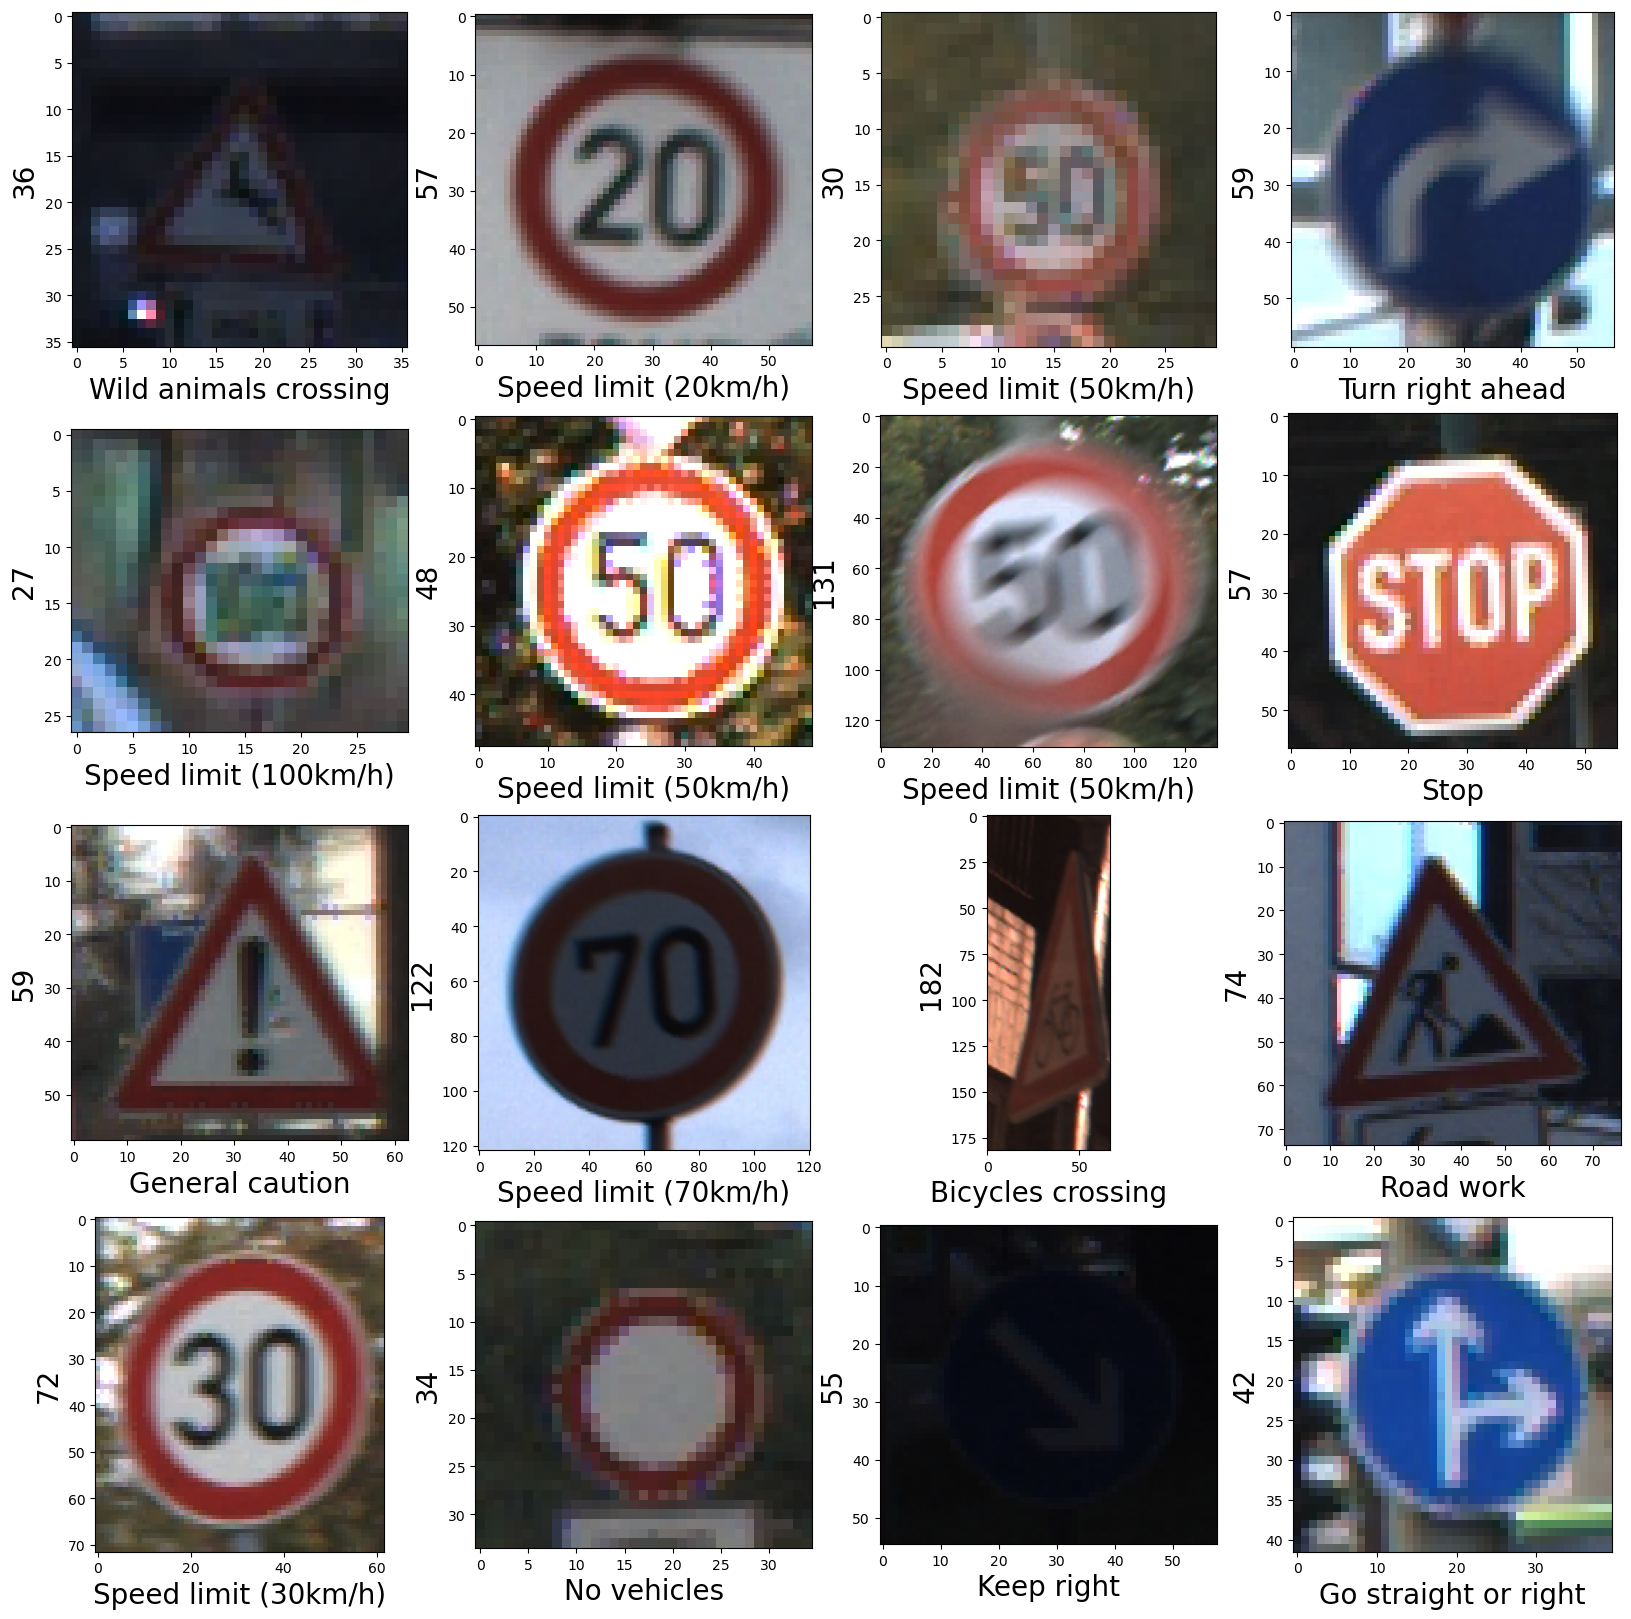

In [8]:
random_sample = train_df.sample(16)
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    img = plt.imread(random_sample['Path'].values.tolist()[i-1])
    plt.imshow(img)
    plt.grid(False)
    plt.xlabel(classes[random_sample['ClassId'].values.tolist()[i-1]], fontsize = 20)
    plt.ylabel(img.shape[0], fontsize = 20)

In [9]:
train_data = train_df.sample(frac=0.8,random_state=42)
val_data = train_df.drop(train_data.index)

NUM_CLASSES = len(classes)
IMG_SIZE = 32

def preprocess_image(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image/255
    return image

def load_data(data):
    X = []
    y = []
    for path, label in zip(data['Path'].values.tolist(), data['ClassId'].values.tolist()):
        image = cv2.imread(path)
        image = preprocess_image(image)
        X.append(image)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_data(train_data)
X_val, y_val = load_data(val_data)
X_test, y_test = load_data(test_df)

In [10]:
print(f'The shape of X_train : {X_train.shape}')
print(f'The shape of X_test : {y_train.shape}')

The shape of X_train : (31367, 32, 32, 3)
The shape of X_test : (31367,)


In [11]:
X_train

array([[[[0.15686275, 0.22352941, 0.41176471],
         [0.14901961, 0.21176471, 0.37254902],
         [0.1372549 , 0.2       , 0.30588235],
         ...,
         [0.17254902, 0.32941176, 0.54509804],
         [0.19607843, 0.34117647, 0.54509804],
         [0.2745098 , 0.44705882, 0.70588235]],

        [[0.18039216, 0.25882353, 0.41568627],
         [0.16078431, 0.23137255, 0.36078431],
         [0.13333333, 0.21176471, 0.34901961],
         ...,
         [0.09411765, 0.22745098, 0.37254902],
         [0.08627451, 0.20784314, 0.26666667],
         [0.12941176, 0.27843137, 0.36470588]],

        [[0.18431373, 0.2745098 , 0.44705882],
         [0.14509804, 0.25098039, 0.38039216],
         [0.11764706, 0.23529412, 0.39215686],
         ...,
         [0.10588235, 0.22745098, 0.35294118],
         [0.07843137, 0.20392157, 0.2627451 ],
         [0.08627451, 0.21960784, 0.29019608]],

        ...,

        [[0.12156863, 0.2       , 0.36862745],
         [0.14901961, 0.21568627, 0.36078431]

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Train on 31367 samples, validate on 7842 samples
Epoch 1/10
31367/31367 [==============================] - 11s 357us/step - loss: 1.7958 - accuracy: 0.4838 - val_loss: 0.4201 - val_accuracy: 0.8905
Epoch 2/10
31367/31367 [==============================] - 11s 355us/step - loss: 0.4059 - accuracy: 0.8728 - val_loss: 0.1535 - val_accuracy: 0.9532
Epoch 3/10
31367/31367 [==============================] - 12s 387us/step - loss: 0.2041 - accuracy: 0.9378 - val_loss: 0.0828 - val_accuracy: 0.9796
Epoch 4/10
31367/31367 [==============================] - 11s 354us/step - loss: 0.1358 - accuracy: 0.9587 - val_loss: 0.0614 - val_accuracy: 0.9820
Epoch 5/10
31367/31367 [==============================] - 11s 351us/step - loss: 0.0985 - accuracy: 0.9690 - val_loss: 0.0468 - val_accuracy: 0.9864
Epoch 6/10
31367/31367 [==============================] - 11s 353us/step - loss: 0.0818 - accuracy: 0.9752 - val_loss: 0.0422 - val_accuracy: 0.9881
Epoch 7/10
31367/31367 [==============================] 

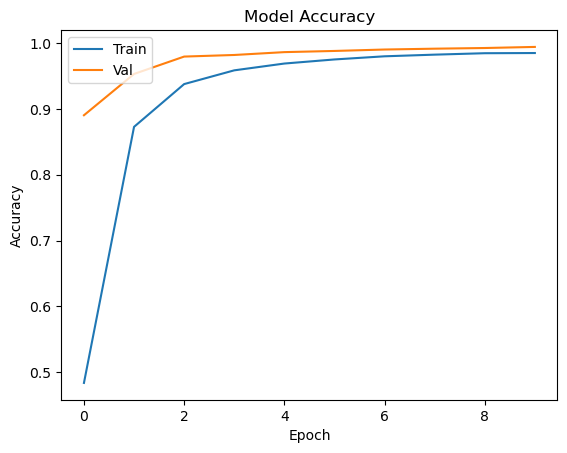

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [28]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
labels = test_df["ClassId"].values
print("Accuracy: ", model.evaluate(X_test, labels)[1])

12630/12630 [==============================] - 1s 95us/step
Accuracy:  0.9585906863212585


<AxesSubplot:>

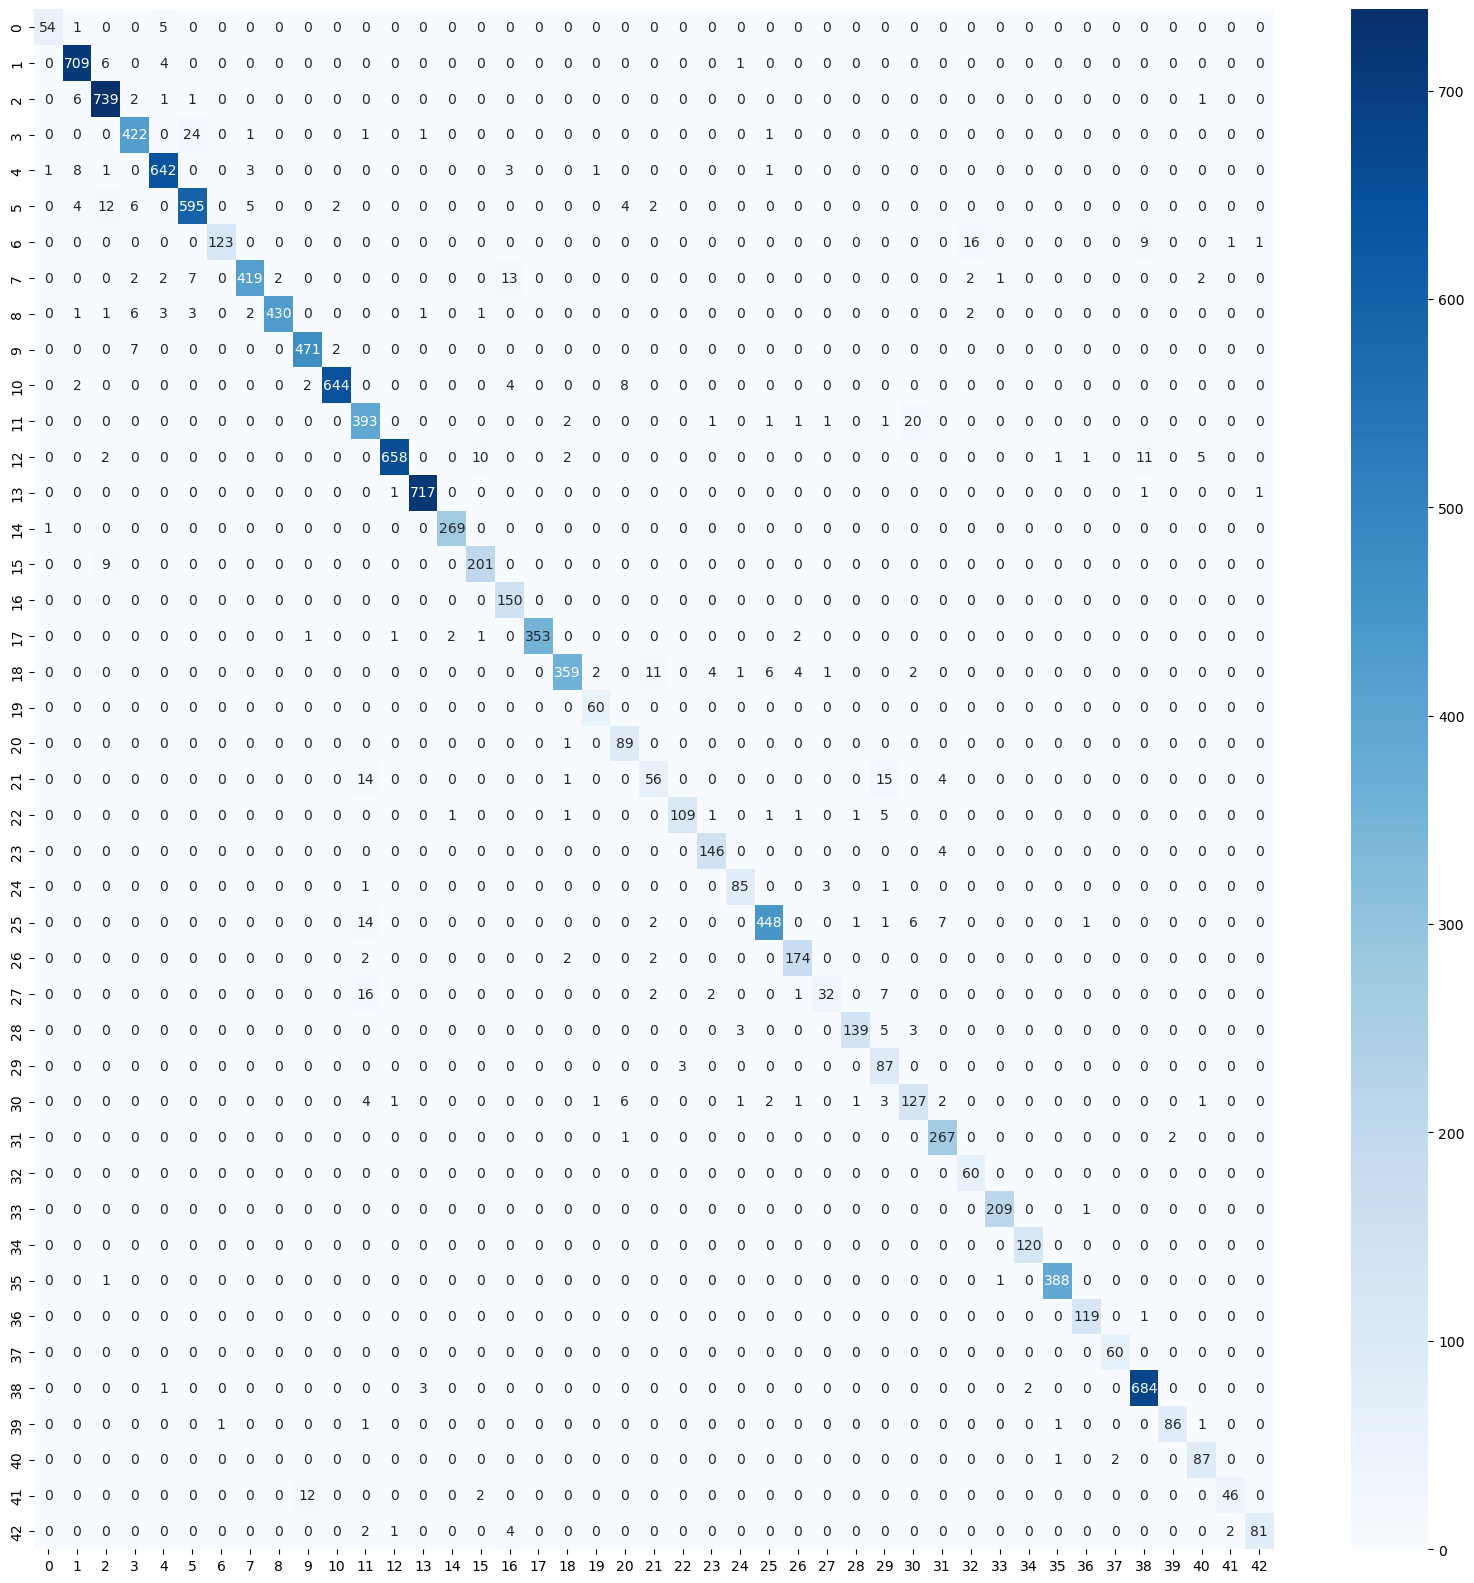

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, y_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [16]:
true_pred = np.where(y_pred_classes == labels)[0]
print("Number of false predictions = ", len(true_pred))

Number of false predictions =  12107


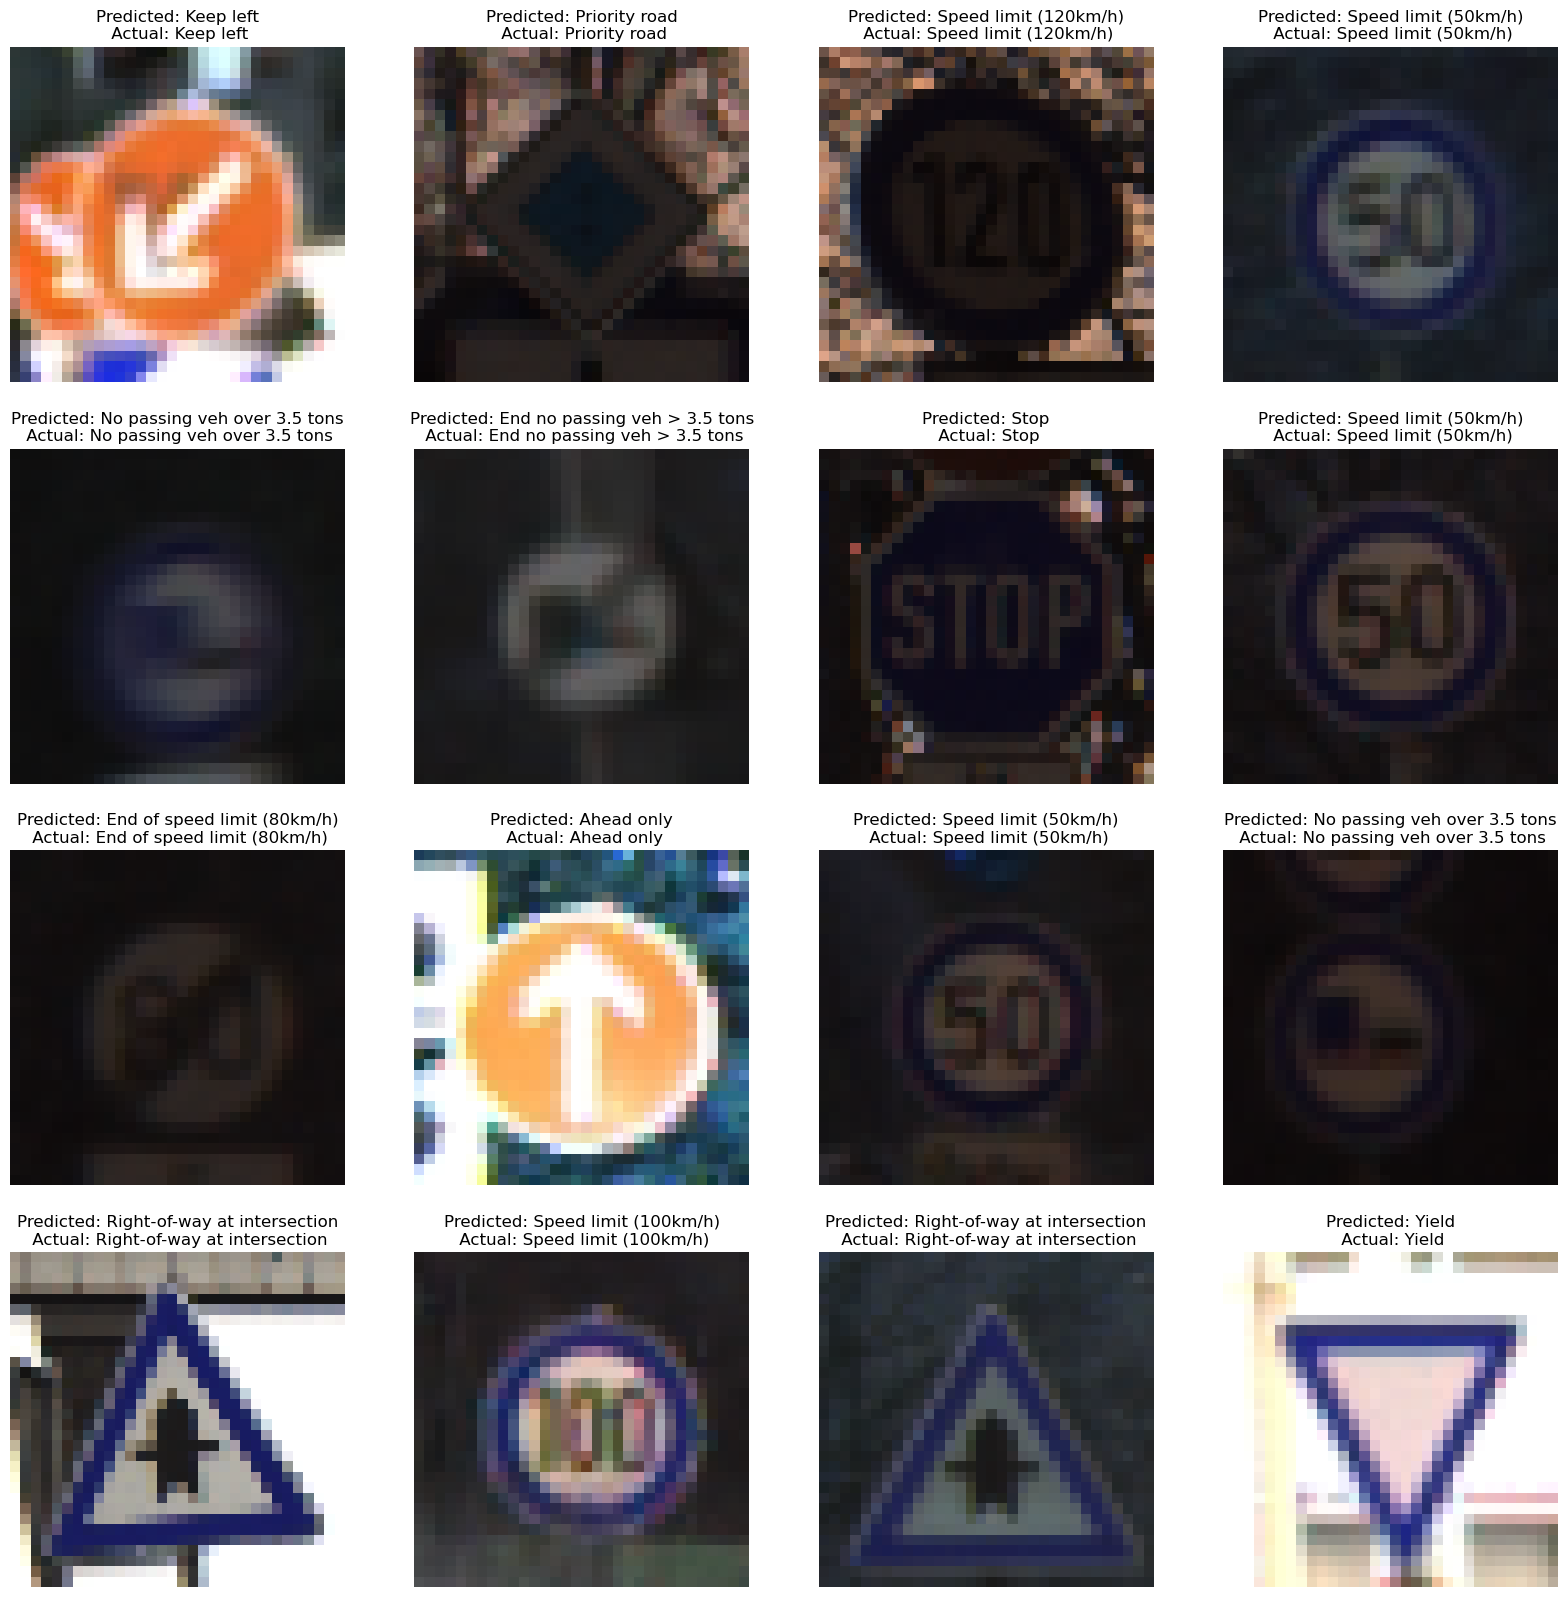

In [17]:
np.random.seed(42)
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
for i, index in enumerate(np.random.choice(true_pred, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.2)

In [21]:
# sample_test = test_df.sample(16)
# 
# fig, axs = plt.subplots(4,4, figsize=(20, 20))
# axs = axs.ravel()
# for i in np.arange(0, 16):
#     img = plt.imread(sample_test['Path'].values.tolist()[i])
#     axs[i].imshow(img)
#     if classes[y_pred_classes[i]] == classes[labels[i]]:
#         color = "green"
#     else:
#         color = "red"
#     axs[i].set_title("Prediction ={}\n True={}".format(classes[y_pred_classes[i]], classes[labels[i]]), color=color)
#     
#     axs[i].axis('off')
# plt.subplots_adjust(wspace=.2)

In [19]:
false_pred = np.where(y_pred_classes != labels)[0]
print("Number of false predictions = ", len(false_pred))

Number of false predictions =  523


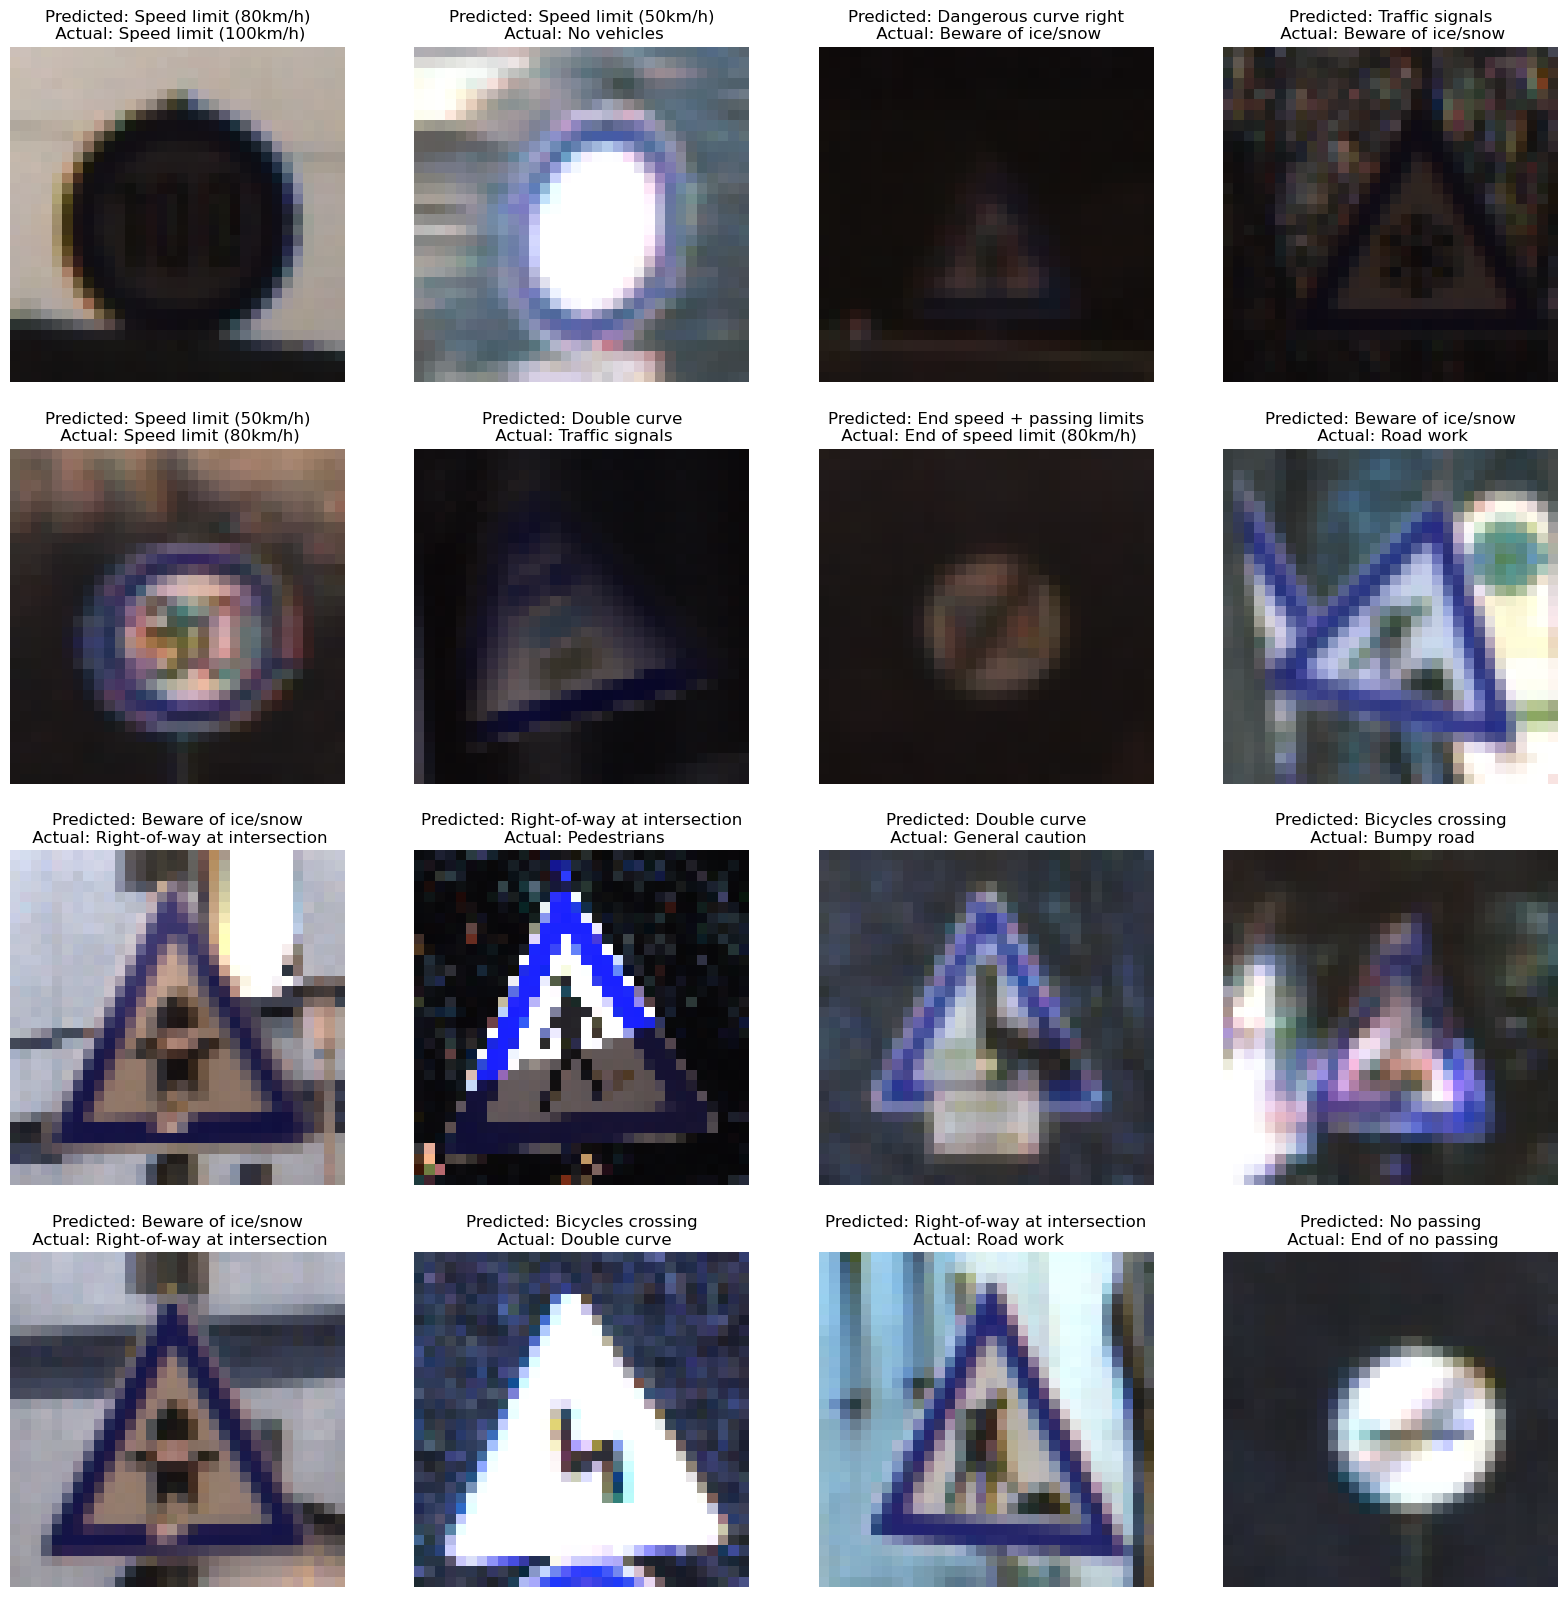

In [25]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
np.random.seed(42)
random_false_pred = np.random.choice(false_pred, 16, replace=False)
for i, index in enumerate(random_false_pred):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.2)